* Natalia Velasco García - A01638047

* Javier Lizarraga Beyles - A01253105

* Jose Luis Rosas Cruz - A01638241

* Cesar Ivann Llamas Macias - A01625272

# Driving Behavior

In [112]:
#!pip install -q kaggle
#from google.colab import files

In [113]:
#files.upload()

In [114]:
#!rm -r ~/.kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json

In [115]:
#! kaggle datasets download outofskills/driving-behavior

In [116]:
#! unzip "/content/driving-behavior.zip"

In [117]:
#from google.colab import drive
#drive.mount('/content/drive')

In [118]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import math

In [119]:
url = "./test_motion_data.csv"
t_test = pd.read_csv(url)

url = "./train_motion_data.csv"
t_train = pd.read_csv(url)

In [120]:
t_train.head(3)

AccX      AccY      AccZ     GyroX     GyroY     GyroZ   Class  \
0  0.000000  0.000000  0.000000  0.059407 -0.174707  0.101938  NORMAL   
1 -1.624864 -1.082492 -0.204183 -0.028558  0.051313  0.135536  NORMAL   
2 -0.594660 -0.122410  0.220502 -0.019395 -0.029322  0.087888  NORMAL   

   Timestamp  
0    3581629  
1    3581630  
2    3581630

In [121]:
t_test.head(3)

AccX      AccY      AccZ     GyroX     GyroY     GyroZ       Class  \
0  0.758194 -0.217791  0.457263  0.000000  0.000000  0.000000  AGGRESSIVE   
1  0.667560 -0.038610  0.231416 -0.054367 -0.007712  0.225257  AGGRESSIVE   
2  2.724449 -7.584121  2.390926  0.023824  0.013668 -0.038026  AGGRESSIVE   

   Timestamp  
0     818922  
1     818923  
2     818923

# Limpieza de datos

Es necesario imputar los datos vacíos, este data frame tiene los datos completos.

In [122]:
print(t_train.isnull().sum())

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64


In [123]:
print(t_test.isnull().sum())

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64


Las observaciones duplicadas deben de ser eliminadas, en este caso todas son únicas.

In [124]:
t_train.duplicated().sum()

0

In [125]:
t_test.duplicated().sum()

0

El timetamp no será considerado un predictor, porque solo indica que las observaciones del dataset fueron hechas en este orden, no da información significativa sobre las clases.

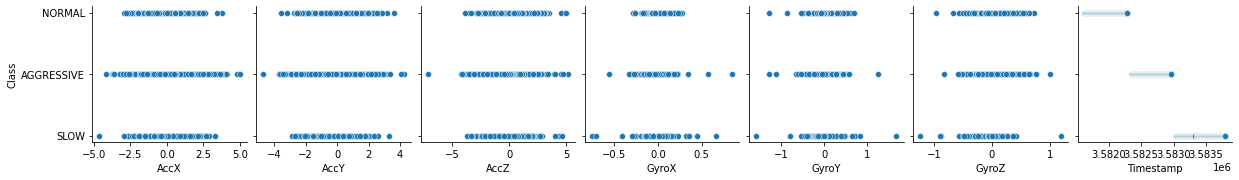

In [126]:
sns.pairplot(
    t_train,
    x_vars=["AccX", "AccY", "AccZ",  "GyroX", "GyroY", "GyroZ", "Timestamp"],
    y_vars=["Class"],
)
plt.show()

Para poder analizar todas las columnas los valores categóricos serán codificados.

In [127]:
t_train = t_train.replace({"Class":  {"SLOW":0, "NORMAL":1, "AGGRESSIVE":2} })

In [128]:
t_test = t_test.replace({"Class":  {"SLOW":0, "NORMAL":1, "AGGRESSIVE":2} })

Las variables predictoras tienen diferentes unidades de medida, deben de se escaladas para el entrenamiento de los modelos.

In [129]:
from sklearn.preprocessing import StandardScaler

In [130]:
scaler = StandardScaler()

In [131]:
t_train.iloc[:, 0:6] = scaler.fit_transform(t_train.iloc[:, 0:6])
t_train.iloc[:, 7:] = scaler.fit_transform(t_train.iloc[:, 7:])

### Valores atípicos

#### IQR score

Para obtener un buen modelo es necesario eliminar el ruido. El boxplot o la gráfica de cajas son útiles para identificar valores atípicos o valores extremos, por medio del rango intercuartil.

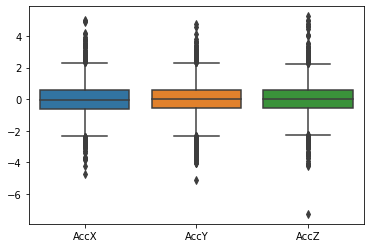

In [132]:
sns.boxplot(data=t_train[['AccX',	'AccY',	'AccZ']])

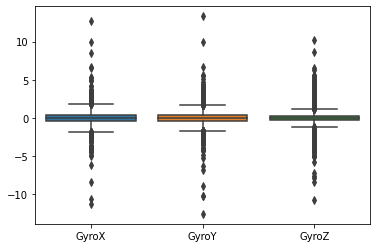

In [133]:
sns.boxplot(data=t_train[['GyroX',	'GyroY',	'GyroZ']])


In [134]:
t_train_x = t_train[["AccX", "AccY", "AccZ",  "GyroX", "GyroY", "GyroZ"]]
Q1 = t_train_x.quantile(0.25)
Q3 = t_train_x.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

AccX     1.163533
AccY     1.156824
AccZ     1.131680
GyroX    0.903855
GyroY    0.832640
GyroZ    0.607322
dtype: float64


Con este método se eliminan demasiados datos, por lo que consideramos que quita información significativa.

In [135]:
t_trainIQR = t_train[((t_train_x > (Q1 - 1.5 * IQR)) & (t_train_x < (Q3 + 1.5 * IQR))).all(axis=1)]

print("t_train", t_train.shape)
print("t_trainIQR", t_trainIQR.shape)

t_train (3644, 8)
t_trainIQR (2808, 8)


#### Z-value
El z-value nos indica a cuantas desviaciones estándar estan nuestros datos de la media, utilizamos este valor para limpiar las columnas que esten muy alejadas de este valor, de esta manera tenemos una cantidad menor de datos y hace mas fácil y eficiente su análisis.

In [136]:
t_trainZ = np.abs(stats.zscore(t_train))

threshold = 3

t_trainZ = t_train[(t_trainZ < threshold).all(axis=1)]
t_trainZ.index = range(len(t_trainZ))

print("t_train", t_train.shape)
print("t_trainZ", t_trainZ.shape)

t_train (3644, 8)
t_trainZ (3395, 8)


# Análisis de datos

Variables independientes:
 - AccX, AccY, AccZ: aceleración en los ejes x, y, z en ($\frac{m}{s^{2}}$).
 - GyroX, GyroY, GyroZ: rotación en los ejes x, y, z en ($\frac{°}{s}$).
 - Timestamp: tiempo en segundos.

Variable dependiente:
 - SLOW, NORMAL, AGGRESSIVE: clasificación de conductores.

In [137]:
t_trainZ.describe()

AccX         AccY         AccZ        GyroX        GyroY  \
count  3395.000000  3395.000000  3395.000000  3395.000000  3395.000000   
mean     -0.014695     0.012828    -0.005078    -0.004787    -0.001343   
std       0.905441     0.912685     0.906288     0.764552     0.750430   
min      -2.980979    -2.828303    -2.998210    -2.943075    -2.962243   
25%      -0.584424    -0.563865    -0.567823    -0.423235    -0.401391   
50%      -0.041113    -0.007037    -0.005706     0.005868    -0.004434   
75%       0.527873     0.572462     0.539682     0.434971     0.397363   
max       2.958848     2.998543     2.940324     2.900031     2.967897   

             GyroZ        Class    Timestamp  
count  3395.000000  3395.000000  3395.000000  
mean     -0.020864     0.910162     0.007044  
std       0.657409     0.811961     1.012582  
min      -2.936999     0.000000    -1.678597  
25%      -0.307029     0.000000    -0.927888  
50%      -0.048257     1.000000     0.003489  
75%       0.252764     2.000000     0.902159  
max       2.967230     2.000000     1.688690

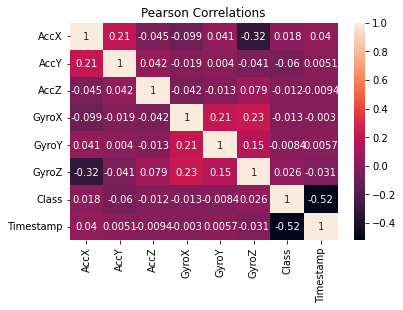

In [138]:
ax = sns.heatmap(t_train.corr(), annot=True).set(title='Pearson Correlations');

Las variables más correlacionadas entre si son:
 - La clase de manera positiva con GyroZ.
 - AccX de manera positiva con AccY.
 - GyroX de manera positiva con GyroY y GyroZ.
 - GyroZ negativamente con AccX.

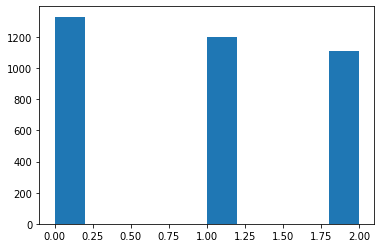

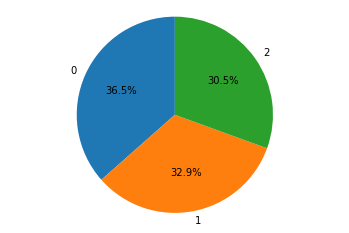

In [139]:
plt.hist(t_train['Class'])

dist = t_train['Class'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(dist, labels=dist.index, autopct='%1.1f%%', startangle=90)
ax1.axis('equal') 

plt.show()

La mayoría de los datos son de la clase SLOW, seguidos por NORMAL y finalizando con AGGRESIVE.

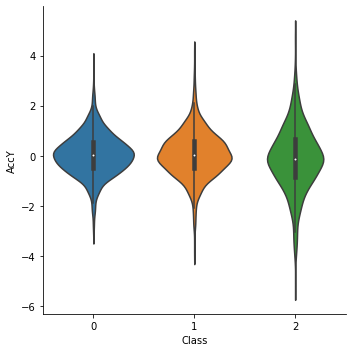

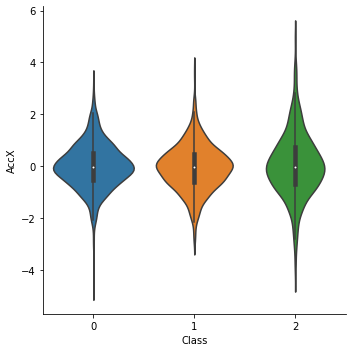

In [140]:
sns.catplot(x='Class', y='AccY', kind='violin', data=t_train)
sns.catplot(x='Class', y='AccX', kind='violin', data=t_train)

En las aceleraciones hacia el frente y lados del carro las clasificaciones tienen más valores alrededor de cero, porque las personas que manejan de manera agresiva cambian de velocidad de manera más abrupta.
No obstante, debemos recordar que los datos fueron tomados por solo un par de personas, por lo que si bien es verdad que los conductores agresivos tienden a hacer cambios de velocidad de manera mas abrupta, estos datos no son representativos.

In [141]:
t_train_a = t_train[t_train['Class'] == 2]
t_train_n = t_train[t_train['Class'] == 1]
t_train_s = t_train[t_train['Class'] == 0]

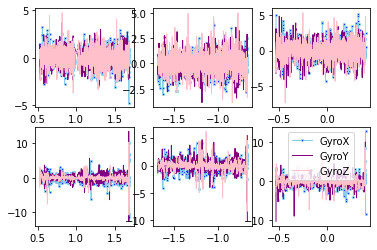

In [142]:
plt.subplot(2, 3, 1)
plt.plot( 'Timestamp', 'AccX', data=t_train_s, marker='o', markerfacecolor='blue', markersize=2, color='skyblue', linewidth=1)
plt.plot( 'Timestamp', 'AccY', data=t_train_s, marker='', color='purple', linewidth=1)
plt.plot( 'Timestamp', 'AccZ', data=t_train_s, marker='', color='pink', linewidth=1)


plt.subplot(2, 3, 2)
plt.plot( 'Timestamp', 'AccX', data=t_train_n, marker='o', markerfacecolor='blue', markersize=2, color='skyblue', linewidth=1)
plt.plot( 'Timestamp', 'AccY', data=t_train_n, marker='', color='purple', linewidth=1)
plt.plot( 'Timestamp', 'AccZ', data=t_train_n, marker='', color='pink', linewidth=1)


plt.subplot(2, 3, 3)
plt.plot( 'Timestamp', 'AccX', data=t_train_a, marker='o', markerfacecolor='blue', markersize=2, color='skyblue', linewidth=1)
plt.plot( 'Timestamp', 'AccY', data=t_train_a, marker='', color='purple', linewidth=1)
plt.plot( 'Timestamp', 'AccZ', data=t_train_a, marker='', color='pink', linewidth=1)

plt.subplot(2, 3, 4)
plt.plot( 'Timestamp', 'GyroX', data=t_train_s, marker='o', markerfacecolor='blue', markersize=2, color='skyblue', linewidth=1)
plt.plot( 'Timestamp', 'GyroY', data=t_train_s, marker='', color='purple', linewidth=1)
plt.plot( 'Timestamp', 'GyroZ', data=t_train_s, marker='', color='pink', linewidth=1)

plt.subplot(2, 3, 5)
plt.plot( 'Timestamp', 'GyroX', data=t_train_n, marker='o', markerfacecolor='blue', markersize=2, color='skyblue', linewidth=1)
plt.plot( 'Timestamp', 'GyroY', data=t_train_n, marker='', color='purple', linewidth=1)
plt.plot( 'Timestamp', 'GyroZ', data=t_train_n, marker='', color='pink', linewidth=1)

plt.subplot(2, 3, 6)
plt.plot( 'Timestamp', 'GyroX', data=t_train_a, marker='o', markerfacecolor='blue', markersize=2, color='skyblue', linewidth=1)
plt.plot( 'Timestamp', 'GyroY', data=t_train_a, marker='', color='purple', linewidth=1)
plt.plot( 'Timestamp', 'GyroZ', data=t_train_a, marker='', color='pink', linewidth=1)

#plt.rcParams['figure.figsize'] = [100, 200]

plt.legend()
plt.show()

## Cálculo de características

En base a las variables dependientes seleccionadas del dataframe se calcularon las siguientes características:

* eucDisAcc: Distancia entre ventanas de tiempo de un segundo entre los datos de aceleración.
* eucDisGy: Distancia entre ventanas de tiempo de un segundo entre los datos del giroscopio.
* eucDisAG: Distancia entre ventanas de tiempo de un segundo entre los datos del giroscopio junto los datos de aceleración.
* accMag: Magnitud del vector de la aceleración.
* gyMag: Magnitud del vector de los datos del giroscopio.

### eucDisAcc y eucDisGy

$n =$ número de datos capturados en un segundo.
$x = (x_1, x_2, ⋯, x_n)$
$y = (y_1, y_2, ⋯, y_n)$
$z = (z_1, z_2, ⋯, z_n)$

Distancia euclidiana entre dos vectores:

$d_L(x, x') = \sqrt{\sum_{i=1}^{n}x_{i}(x_i+x'_i)}$

Para calcular cómo varían las ventanas de tiempo, se calculan los resultados de esta función en los tres ejes y se promedian.

In [143]:
eucDisAcc = [0]
sumX = 0
sumY = 0
sumZ = 0

for i in range(len(t_train['AccX'])-2):
  for j in range(i, i+2):
   sumX += (t_train['AccX'][j]-t_train['AccX'][j+1])**2
   sumY += (t_train['AccY'][j]-t_train['AccY'][j+1])**2
   sumZ += (t_train['AccZ'][j]-t_train['AccZ'][j+1])**2
  
  eucDisAcc.append((math.sqrt(sumX) + math.sqrt(sumY) + math.sqrt(sumZ))/3)
  sumX = 0
  sumY = 0
  sumZ = 0

eucDisAcc.append(0)


In [144]:
from numpy.lib.function_base import average
eucDisGy = [0]
sumX = 0
sumY = 0
sumZ = 0

for i in range(len(t_train['GyroX'])-2):
  for j in range(i, i+2):
   sumX += (t_train['GyroX'][j]-t_train['GyroX'][j+1])**2
   sumY += (t_train['GyroY'][j]-t_train['GyroY'][j+1])**2
   sumZ += (t_train['GyroZ'][j]-t_train['GyroZ'][j+1])**2
  
  eucDisGy.append((math.sqrt(sumX) + math.sqrt(sumY) + math.sqrt(sumZ))/3)
  sumX = 0
  sumY = 0
  sumZ = 0

eucDisGy.append(0)


### eucDisAG

Distancia euclidiana entre dos vectores conformados por los datos de aceleración y giroscopio:

$\frac{1}{6}[d_{L}(x_a, x'_a) + d_{L}(y_a, y'_a) + d_{L}(z_a, z'_a) + d_{L}(x_g, x'_g) + d_{L}(y_g, y'_g) + d_{L}(z_g, z'_g)]$

In [145]:
from numpy.lib.function_base import average
eucDisAG = [0]
sumAX = 0
sumAY = 0
sumAZ = 0
sumGX = 0
sumGY = 0
sumGZ = 0

for i in range(len(t_train['GyroX'])-2):
  for j in range(i, i+2):
  
   sumAX += (t_train['AccX'][j]-t_train['AccX'][j+1])**2
   sumAY += (t_train['AccY'][j]-t_train['AccY'][j+1])**2
   sumAZ += (t_train['AccZ'][j]-t_train['AccZ'][j+1])**2

   sumGX += (t_train['GyroX'][j]-t_train['GyroX'][j+1])**2
   sumGY += (t_train['GyroY'][j]-t_train['GyroY'][j+1])**2
   sumGZ += (t_train['GyroZ'][j]-t_train['GyroZ'][j+1])**2
  
  eucDisAG.append((math.sqrt(sumAX) + math.sqrt(sumAY) + math.sqrt(sumAZ) + math.sqrt(sumGX) + math.sqrt(sumGY) + math.sqrt(sumGZ)) / 6)
  sumAX = 0
  sumAY = 0
  sumAZ = 0
  sumGX = 0
  sumGY = 0
  sumGZ = 0

eucDisAG.append(0)


### accMag

Magnitud de un vector de rotación:

$|\vec{g}|=\sqrt{x^2 + y^2 + z^2}$


In [146]:
accMag = []

for i in range(len(t_train)):
  accMag.append(math.sqrt(t_train['AccX'][i]**2+t_train['AccY'][i]**2+t_train['AccZ'][i]**2))
  

### gyMag

Magnitud de un vector de los datos del giroscopio:

$|\vec{a}|=\sqrt{x^2 + y^2 + z^2}$


In [147]:
gyMag = []

for i in range(len(t_train)):
  gyMag.append(math.sqrt(t_train['GyroX'][i]**2+t_train['GyroY'][i]**2+t_train['GyroZ'][i]**2))

In [148]:
t_train['eucDisAcc'] = eucDisAcc
t_train['eucDisGy'] = eucDisGy
t_train['eucDisAG'] = eucDisAG
t_train['accMag'] = accMag
t_train['gyMag'] = gyMag

t_train = t_train.iloc[1:len(t_train)-1]
len(t_train)

3642

Estas mismas características fueron calculadas con el dataset de testing para poder predecir la variable de respuestas con los modelos.

In [149]:
eucDisAcc = [0]
sumX = 0
sumY = 0
sumZ = 0

for i in range(len(t_test['AccX'])-2):
  for j in range(i, i+2):
   sumX += (t_test['AccX'][j]-t_test['AccX'][j+1])**2
   sumY += (t_test['AccY'][j]-t_test['AccY'][j+1])**2
   sumZ += (t_test['AccZ'][j]-t_test['AccZ'][j+1])**2
  
  eucDisAcc.append((math.sqrt(sumX) + math.sqrt(sumY) + math.sqrt(sumZ))/3)
  sumX = 0
  sumY = 0
  sumZ = 0

eucDisAcc.append(0)


In [150]:
accMag = []

for i in range(len(t_test)):
  accMag.append(math.sqrt(t_test['AccX'][i]**2+t_test['AccY'][i]**2+t_test['AccZ'][i]**2))
  

In [151]:
gyMag = []

for i in range(len(t_test)):
  gyMag.append(math.sqrt(t_test['GyroX'][i]**2+t_test['GyroY'][i]**2+t_test['GyroZ'][i]**2))

In [152]:
from numpy.lib.function_base import average
eucDisGy = [0]
sumX = 0
sumY = 0
sumZ = 0

for i in range(len(t_test['GyroX'])-2):
  for j in range(i, i+2):
   sumX += (t_test['GyroX'][j]-t_test['GyroX'][j+1])**2
   sumY += (t_test['GyroY'][j]-t_test['GyroY'][j+1])**2
   sumZ += (t_test['GyroZ'][j]-t_test['GyroZ'][j+1])**2
  
  eucDisGy.append((math.sqrt(sumX) + math.sqrt(sumY) + math.sqrt(sumZ))/3)
  sumX = 0
  sumY = 0
  sumZ = 0

eucDisGy.append(0)


In [153]:
from numpy.lib.function_base import average
eucDisAG = [0]
sumAX = 0
sumAY = 0
sumAZ = 0
sumGX = 0
sumGY = 0
sumGZ = 0

for i in range(len(t_test['GyroX'])-2):
  for j in range(i, i+2):
  
   sumAX += (t_test['AccX'][j]-t_test['AccX'][j+1])**2
   sumAY += (t_test['AccY'][j]-t_test['AccY'][j+1])**2
   sumAZ += (t_test['AccZ'][j]-t_test['AccZ'][j+1])**2

   sumGX += (t_test['GyroX'][j]-t_test['GyroX'][j+1])**2
   sumGY += (t_test['GyroY'][j]-t_test['GyroY'][j+1])**2
   sumGZ += (t_test['GyroZ'][j]-t_test['GyroZ'][j+1])**2
  
  eucDisAG.append((math.sqrt(sumAX) + math.sqrt(sumAY) + math.sqrt(sumAZ) + math.sqrt(sumGX) + math.sqrt(sumGY) + math.sqrt(sumGZ)) / 6)
  sumAX = 0
  sumAY = 0
  sumAZ = 0
  sumGX = 0
  sumGY = 0
  sumGZ = 0

eucDisAG.append(0)


In [154]:
t_test['eucDisAcc'] = eucDisAcc
t_test['eucDisGy'] = eucDisGy
t_test['eucDisAG'] = eucDisAG
t_test['accMag'] = accMag
t_test['gyMag'] = gyMag

t_test = t_test.iloc[1:len(t_test)-1]
len(t_test)

3082

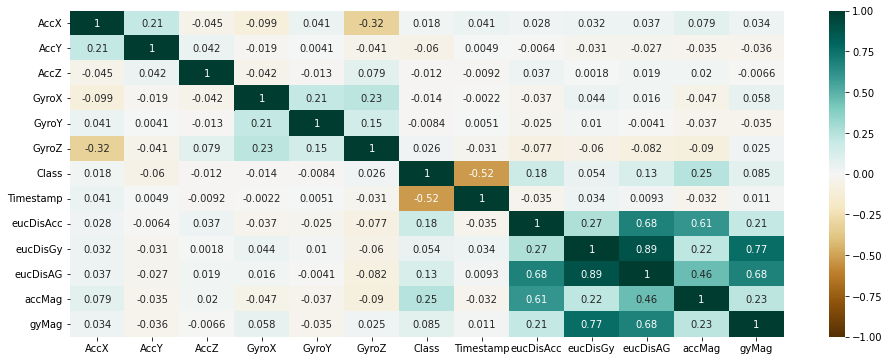

In [155]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(t_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

* Los valores de aggresive se comportan diferente a normal y a slow.
* Slow y normal se comportan igual.

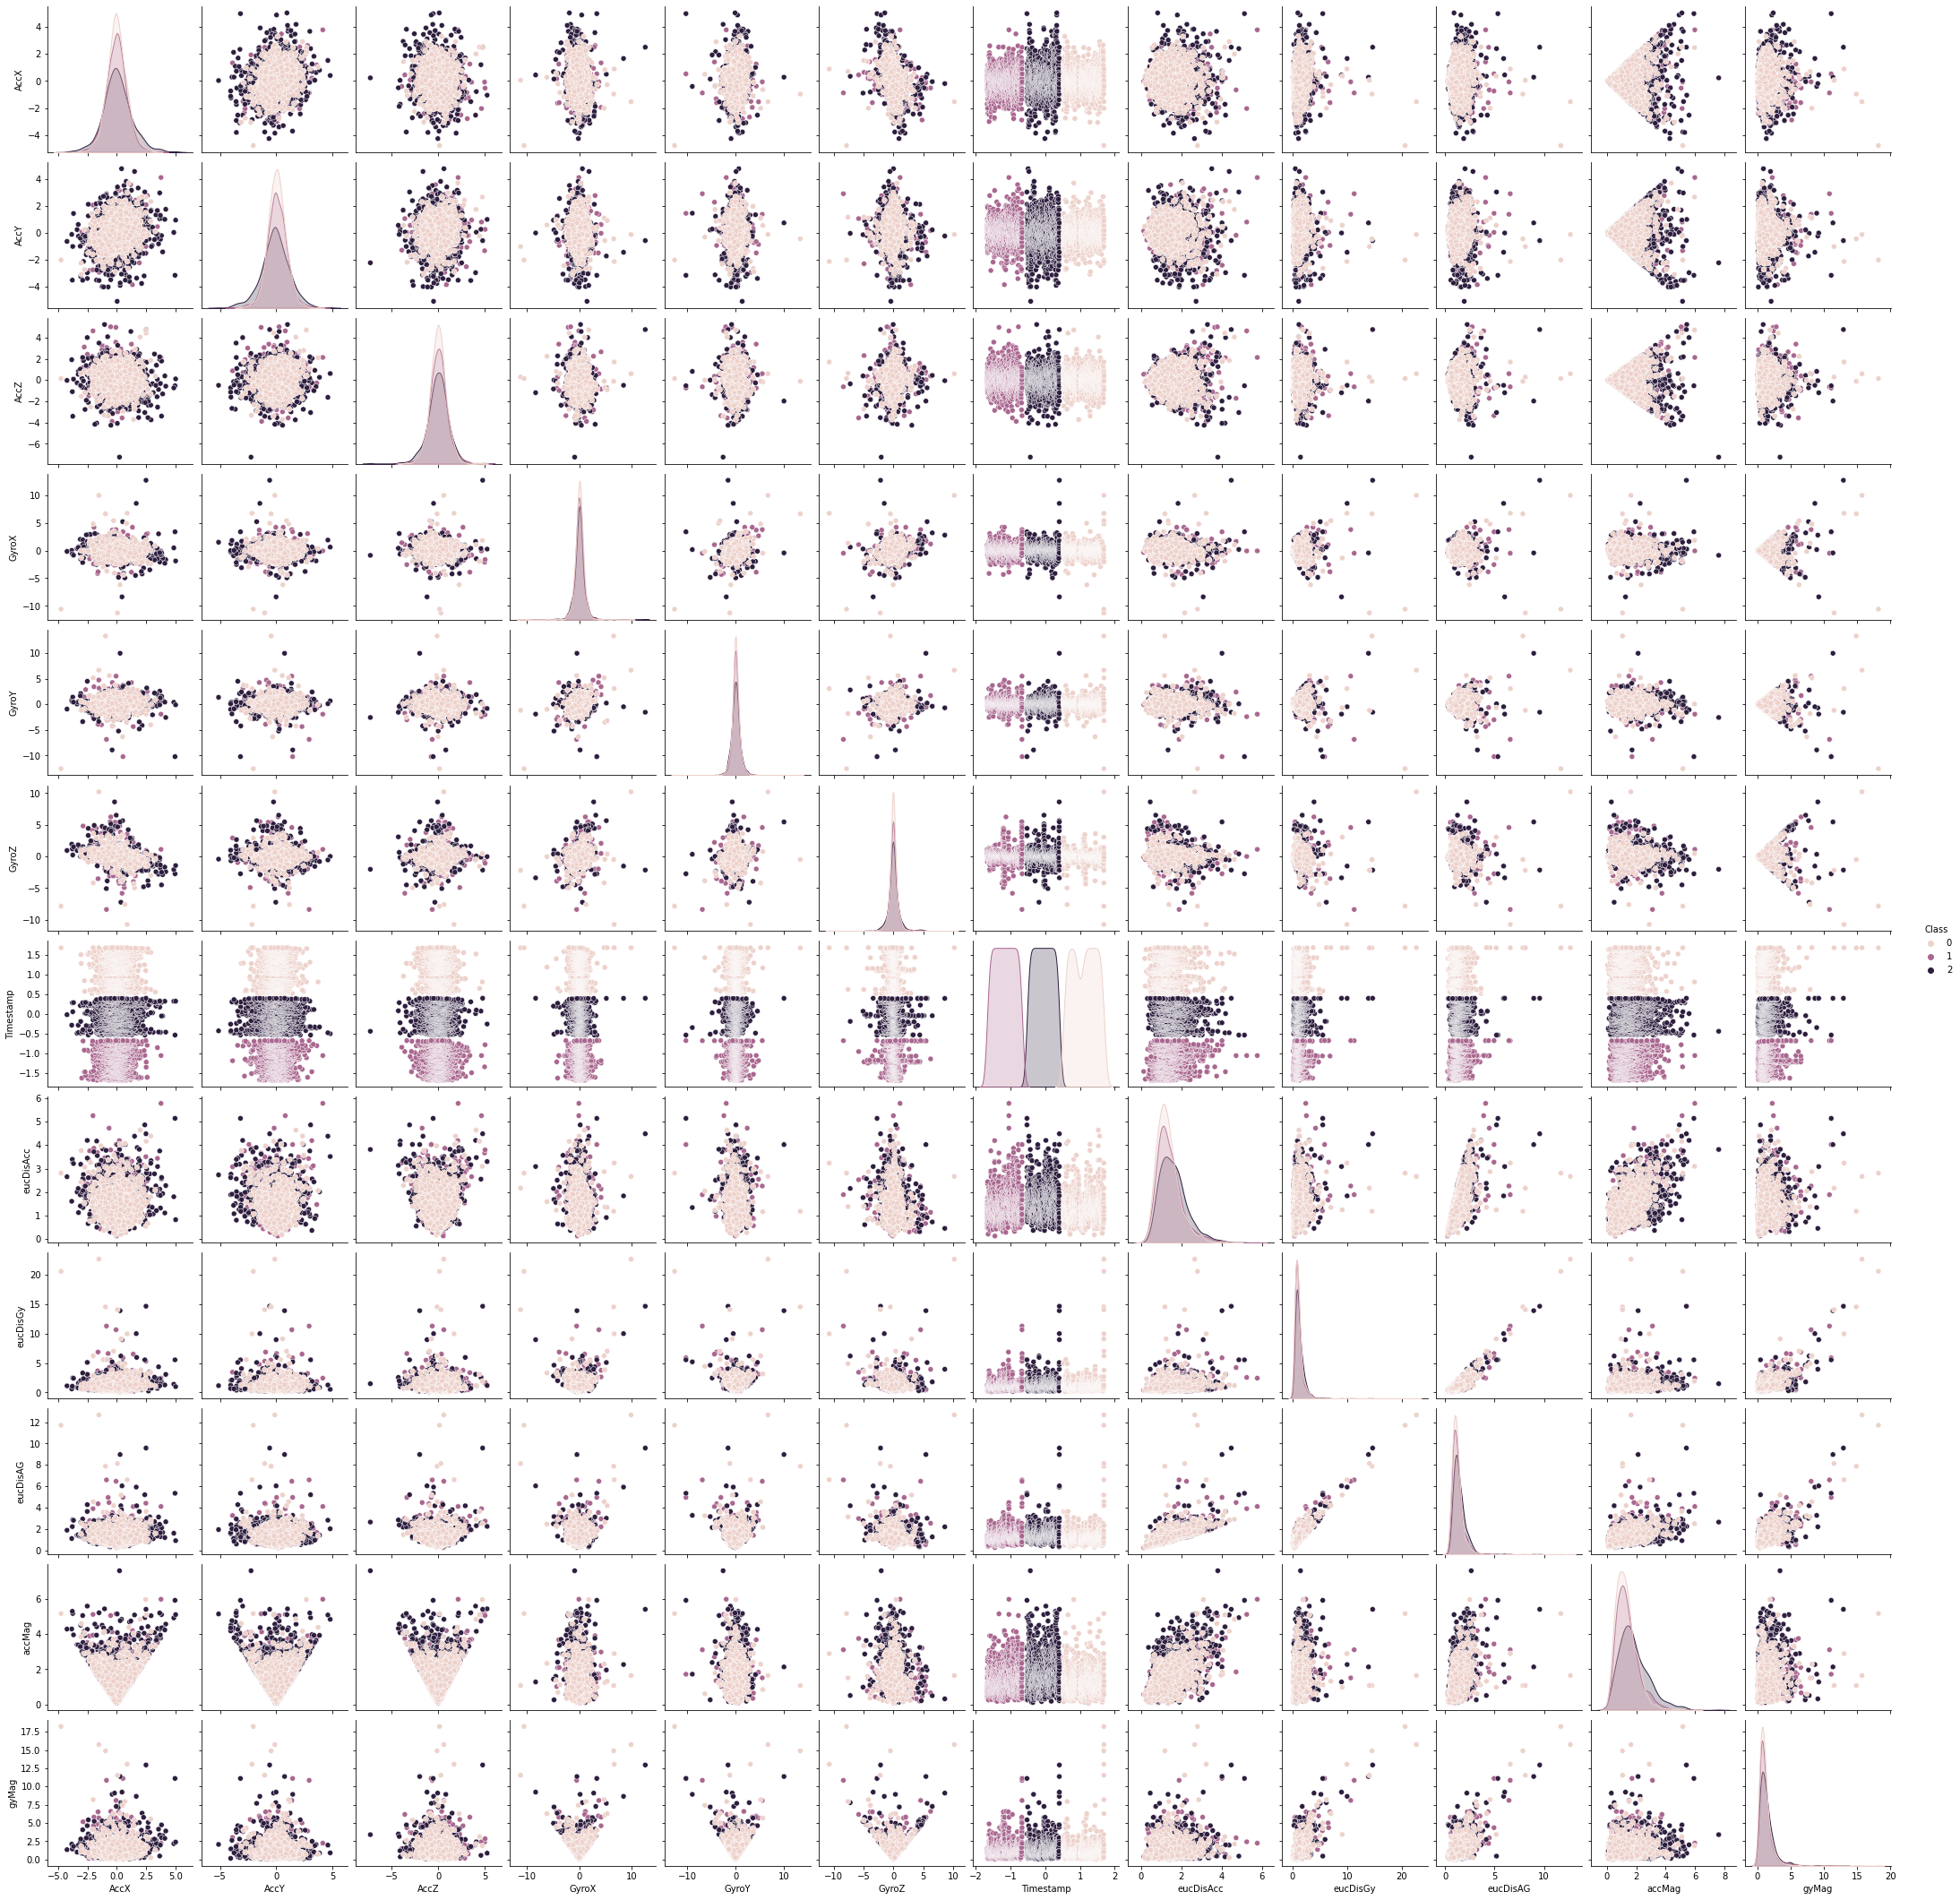

In [156]:
sns.pairplot(t_train, hue="Class")

# Selección de características

In [157]:
from sklearn.feature_selection import RFECV

In [158]:
X = t_train[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'eucDisAcc', 'eucDisGy', 'eucDisAG', 'accMag', 'gyMag']]
#X = t_train[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']]
y  = t_train['Class']

In [159]:
ytest = t_test['Class']

In [160]:
from sklearn.linear_model import LogisticRegression

Para seleccionar las mejores variables, fue utilizada una función de la librería de Sklearn llamada RFECV la cual permite que los modelos tengan una mejor precisión.

In [161]:
selector = RFECV(estimator=LogisticRegression(), step=1, cv=5, scoring='accuracy')
selector = selector.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


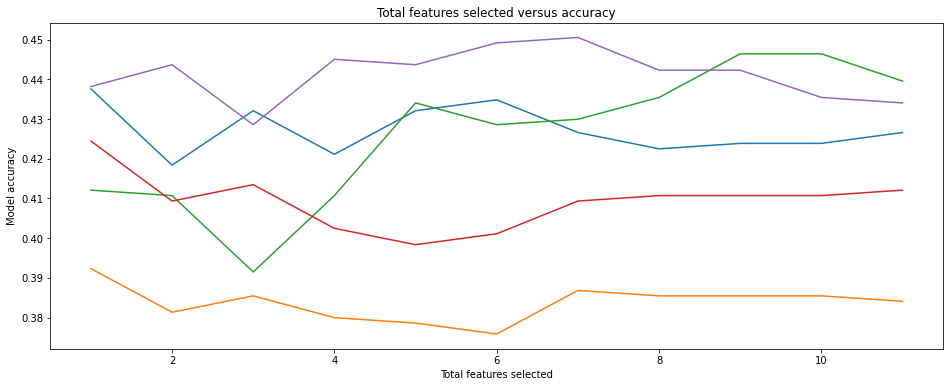

In [162]:
plt.figure( figsize=(16, 6))
plt.title('Total features selected versus accuracy')
plt.xlabel('Total features selected')
plt.ylabel('Model accuracy')
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

La siguiente tabla muestra las variables a utilizar para la implementación de los algoritmo.

In [163]:
features_kept = pd.DataFrame({'columns': X.columns,
                             'Kept': selector.support_})
features_kept

columns   Kept
0        AccX   True
1        AccY   True
2        AccZ   True
3       GyroX   True
4       GyroY  False
5       GyroZ   True
6   eucDisAcc   True
7    eucDisGy   True
8    eucDisAG  False
9      accMag   True
10      gyMag   True

In [164]:
X = t_train[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroZ', 'eucDisAcc', 'eucDisGy', 'accMag', 'gyMag']]
Xtest = t_test[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroZ', 'eucDisAcc', 'eucDisGy', 'accMag', 'gyMag']]

# Modelos

## Regresión logística

In [165]:
logRegModel = LogisticRegression(C=1e5)
logRegModel.fit(X, y)

ypred = logRegModel.predict(Xtest)

print("Exactitud del modelo: ", logRegModel.score(Xtest, ytest))

Exactitud del modelo:  0.4607397793640493


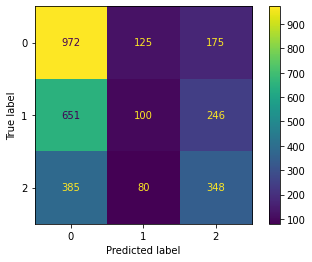

In [166]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

CM = confusion_matrix(ytest, ypred)

CMnorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMnorm.plot()
plt.show()

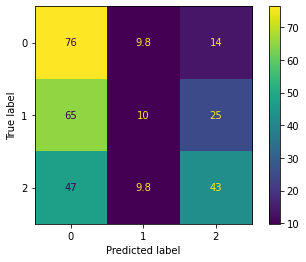

In [167]:
CMnorm = confusion_matrix(ytest, ypred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=CMnorm*100, display_labels=logRegModel.classes_)
disp.plot()
plt.show()

La métrica recall tiene más importancia que la de precision, ya que los falsos negativos son más costosos que los falsos positivos en este proyecto, porque no detectar correctamente cuando un conductor es agresivo, puede ocasionar algún accidente.

In [168]:
precision0 = CM[0][0] / (CM[0][0] + CM[1][0] + CM[2][0])
print("Precision 0:",precision0*100)
recall0 = CM[0][0] / (CM[0][0] + CM[0][1] + CM[0][2])
print("Recall 0:",recall0*100, "\n")

precision1 = CM[1][1] / (CM[0][1] + CM[1][1] + CM[2][1])
print("Precision 1:",precision1*100)
recall1 = CM[1][1] / (CM[1][0] + CM[1][1] + CM[1][2])
print("Recall 1:",recall1*100, "\n")

precision2 = CM[2][2] / (CM[0][2] + CM[1][2] + CM[2][2])
print("Precision 2:",precision2*100)
recall2 = CM[2][2] / (CM[2][0] + CM[2][1] + CM[2][2])
print("Recall 2:",recall2*100)

Precision 0: 48.40637450199203
Recall 0: 76.41509433962264 

Precision 1: 32.78688524590164
Recall 1: 10.030090270812437 

Precision 2: 45.25357607282184
Recall 2: 42.80442804428044


## Bayes

In [169]:
from sklearn.naive_bayes import GaussianNB

In [170]:
nb = GaussianNB()
nb.fit(X, y)
ypred = nb.predict(Xtest)

print("Exactitud del modelo", nb.score(Xtest, ytest))


Exactitud del modelo 0.46236210253082416


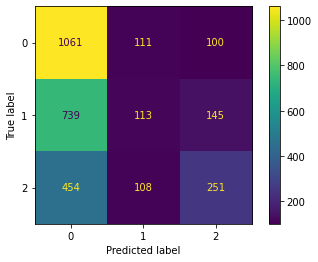

In [171]:
CM = confusion_matrix(ytest, ypred)

CMnorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMnorm.plot()
plt.show()

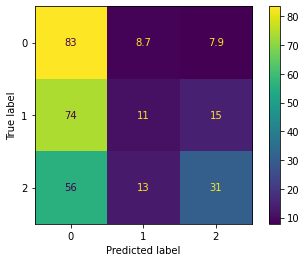

In [172]:
CMnorm = confusion_matrix(ytest, ypred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=CMnorm*100, display_labels=logRegModel.classes_)
disp.plot()
plt.show()

In [173]:
precision0 = CM[0][0] / (CM[0][0] + CM[1][0] + CM[2][0])
print("Precision 0:",precision0*100)
recall0 = CM[0][0] / (CM[0][0] + CM[0][1] + CM[0][2])
print("Recall 0:",recall0*100, "\n")

precision1 = CM[1][1] / (CM[0][1] + CM[1][1] + CM[2][1])
print("Precision 1:",precision1*100)
recall1 = CM[1][1] / (CM[1][0] + CM[1][1] + CM[1][2])
print("Recall 1:",recall1*100, "\n")

precision2 = CM[2][2] / (CM[0][2] + CM[1][2] + CM[2][2])
print("Precision 2:",precision2*100)
recall2 = CM[2][2] / (CM[2][0] + CM[2][1] + CM[2][2])
print("Recall 2:",recall2*100)

Precision 0: 47.07187222715173
Recall 0: 83.4119496855346 

Precision 1: 34.036144578313255
Recall 1: 11.334002006018054 

Precision 2: 50.60483870967742
Recall 2: 30.873308733087327


## KNN

In [174]:
from sklearn.neighbors import KNeighborsClassifier

In [175]:
error = []

for i in range(1,200):
 kNN = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
 kNN.fit(X, y)
 ypred = kNN.predict(Xtest)
 error.append(np.mean(ypred != ytest))

k = error.index(min(error))
print("Minimum error:-",min(error))
print("k = ", k)

Minimum error:- 0.5425048669695003
k =  167


In [176]:
kNN    = KNeighborsClassifier(n_neighbors=k)
kNN.fit(X, y)
ypred = kNN.predict(Xtest)

print("Exactitud del modelo", kNN.score(Xtest, ytest))

Exactitud del modelo 0.4516547696301103


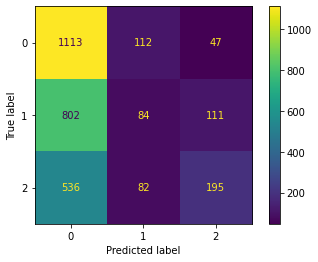

In [177]:
CM = confusion_matrix(ytest, ypred)

CMnorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMnorm.plot()
plt.show()

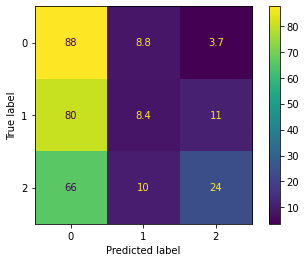

In [178]:
CMnorm = confusion_matrix(ytest, ypred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=CMnorm*100, display_labels=logRegModel.classes_)
disp.plot()
plt.show()

In [179]:
precision0 = CM[0][0] / (CM[0][0] + CM[1][0] + CM[2][0])
print("Precision 0:",precision0*100)
recall0 = CM[0][0] / (CM[0][0] + CM[0][1] + CM[0][2])
print("Recall 0:",recall0*100, "\n")

precision1 = CM[1][1] / (CM[0][1] + CM[1][1] + CM[2][1])
print("Precision 1:",precision1*100)
recall1 = CM[1][1] / (CM[1][0] + CM[1][1] + CM[1][2])
print("Recall 1:",recall1*100, "\n")

precision2 = CM[2][2] / (CM[0][2] + CM[1][2] + CM[2][2])
print("Precision 2:",precision2*100)
recall2 = CM[2][2] / (CM[2][0] + CM[2][1] + CM[2][2])
print("Recall 2:",recall2*100)

Precision 0: 45.41003671970624
Recall 0: 87.5 

Precision 1: 30.215827338129497
Recall 1: 8.425275827482448 

Precision 2: 55.240793201133144
Recall 2: 23.985239852398525


## Random forest

In [180]:
from sklearn.ensemble import RandomForestClassifier

In [181]:
rfc = RandomForestClassifier()
rfc.fit(X, y)
ypred = rfc.predict(Xtest)

print("Exactitud del modelo", rfc.score(Xtest, ytest))

Exactitud del modelo 0.4399740428293316


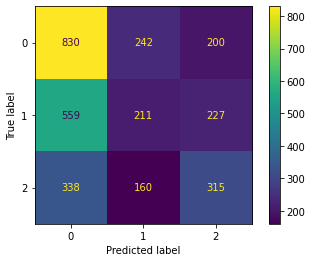

In [182]:
CM = confusion_matrix(ytest, ypred)

CMnorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMnorm.plot()
plt.show()

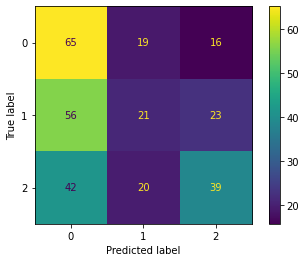

In [183]:
CMnorm = confusion_matrix(ytest, ypred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=CMnorm*100, display_labels=logRegModel.classes_)
disp.plot()
plt.show()

In [184]:
precision0 = CM[0][0] / (CM[0][0] + CM[1][0] + CM[2][0])
print("Precision 0:",precision0*100)
recall0 = CM[0][0] / (CM[0][0] + CM[0][1] + CM[0][2])
print("Recall 0:",recall0*100, "\n")

precision1 = CM[1][1] / (CM[0][1] + CM[1][1] + CM[2][1])
print("Precision 1:",precision1*100)
recall1 = CM[1][1] / (CM[1][0] + CM[1][1] + CM[1][2])
print("Recall 1:",recall1*100, "\n")

precision2 = CM[2][2] / (CM[0][2] + CM[1][2] + CM[2][2])
print("Precision 2:",precision2*100)
recall2 = CM[2][2] / (CM[2][0] + CM[2][1] + CM[2][2])
print("Recall 2:",recall2*100)

Precision 0: 48.06022003474233
Recall 0: 65.25157232704403 

Precision 1: 34.42088091353997
Recall 1: 21.163490471414242 

Precision 2: 42.45283018867924
Recall 2: 38.74538745387454


## kmeans

In [185]:
from sklearn.cluster import KMeans

In [186]:
km =  KMeans(n_clusters=3, random_state=0).fit(X)
ypred = km.predict(Xtest)

print("Exactitud del modelo", km.score(Xtest, ytest))

Exactitud del modelo -16977.878589487507


In [187]:
print("Inercia del modelo", km.inertia_)

Inercia del modelo 24764.605386991552


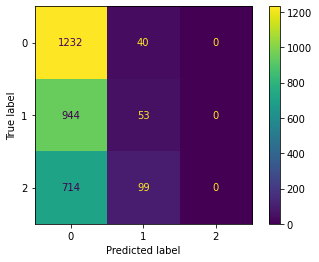

In [188]:
CM = confusion_matrix(ytest, ypred)

CMnorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMnorm.plot()
plt.show()

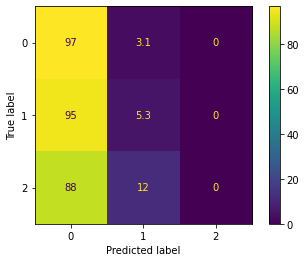

In [189]:
CMnorm = confusion_matrix(ytest, ypred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=CMnorm*100, display_labels=logRegModel.classes_)
disp.plot()
plt.show()

In [190]:
precision0 = CM[0][0] / (CM[0][0] + CM[1][0] + CM[2][0])
print("Precision 0:",precision0*100)
recall0 = CM[0][0] / (CM[0][0] + CM[0][1] + CM[0][2])
print("Recall 0:",recall0*100, "\n")

precision1 = CM[1][1] / (CM[0][1] + CM[1][1] + CM[2][1])
print("Precision 1:",precision1*100)
recall1 = CM[1][1] / (CM[1][0] + CM[1][1] + CM[1][2])
print("Recall 1:",recall1*100, "\n")

precision2 = CM[2][2] / (CM[0][2] + CM[1][2] + CM[2][2])
print("Precision 2:",precision2*100)
recall2 = CM[2][2] / (CM[2][0] + CM[2][1] + CM[2][2])
print("Recall 2:",recall2*100)

Precision 0: 42.62975778546713
Recall 0: 96.85534591194968 

Precision 1: 27.604166666666668
Recall 1: 5.315947843530592 

Precision 2: nan
Recall 2: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


# Drop normal

In [191]:
t_train.drop(t_train[t_train['Class'] == 0].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [192]:
t_test.drop(t_test[t_test['Class'] == 0].index, inplace=True)

In [193]:
t_train["Class"] = np.where(t_train["Class"] == 1, 0,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [194]:
t_test["Class"] = np.where(t_test["Class"] == 1, 0,1)

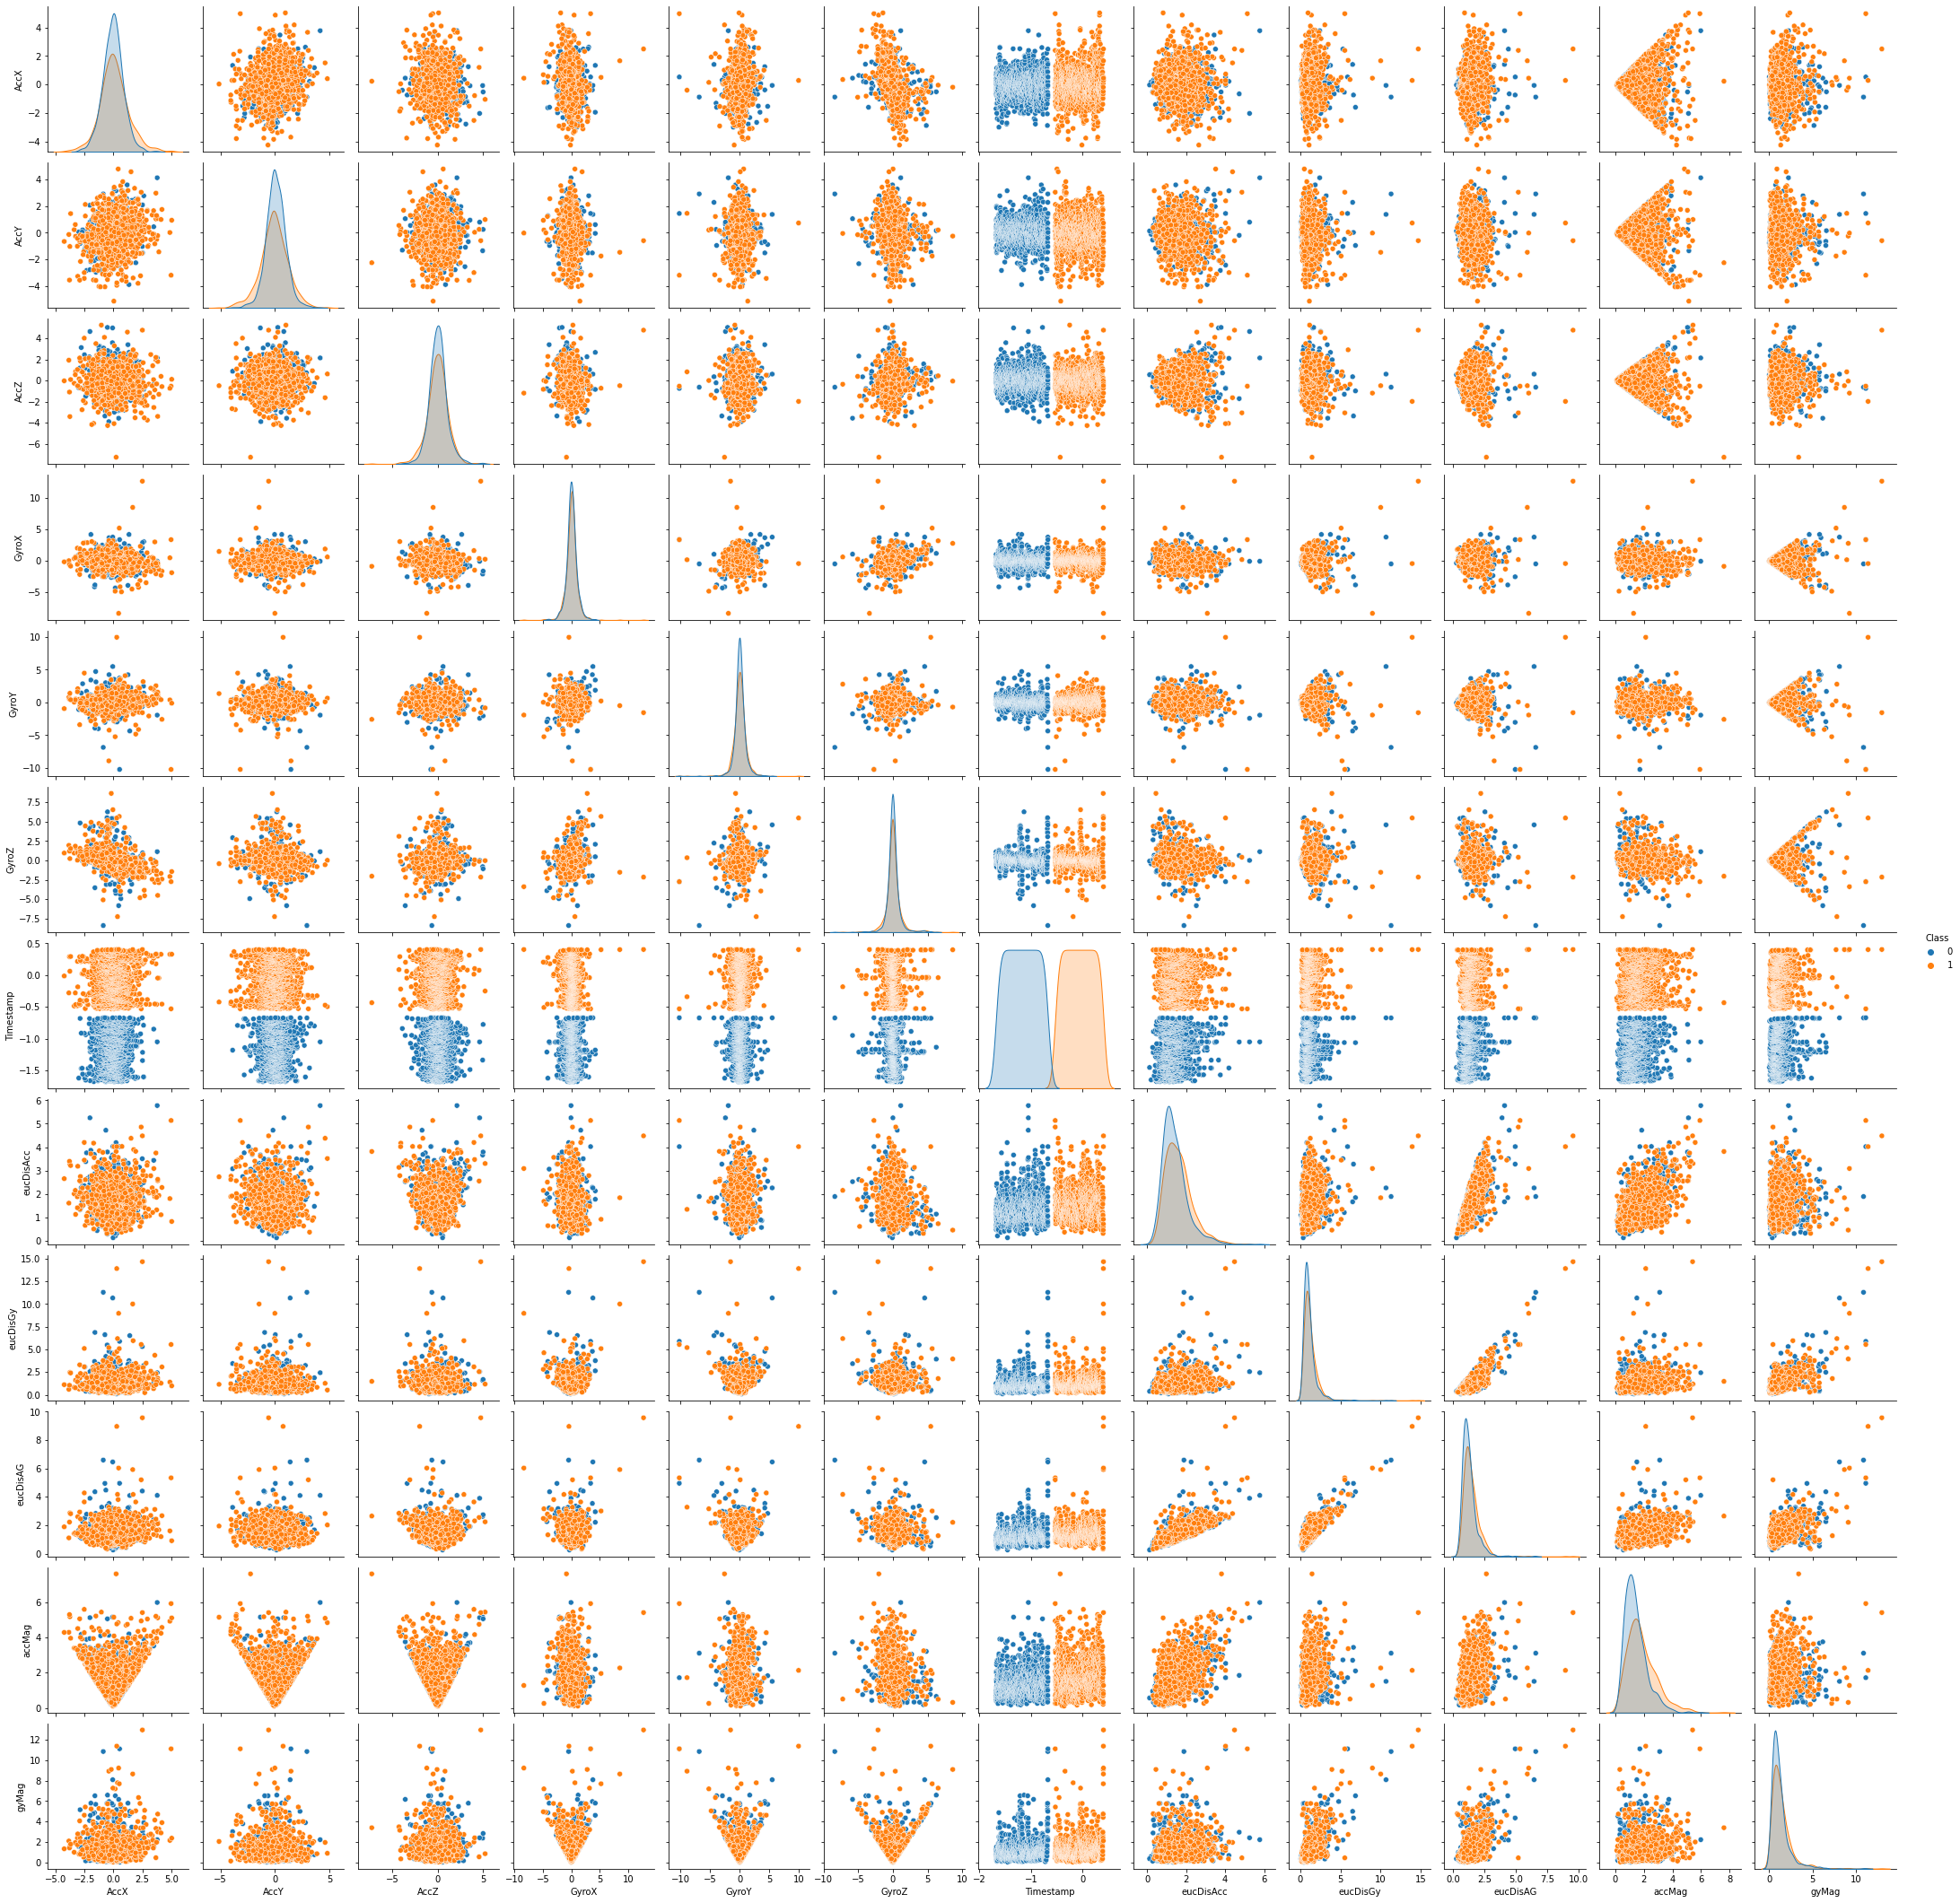

In [195]:
sns.pairplot(t_train, hue="Class")

# Models

## Regresion logistica

In [196]:
X = t_train[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroZ', 'eucDisAcc', 'eucDisGy', 'accMag', 'gyMag']]
y  = t_train['Class']

In [197]:
Xtest = t_test[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroZ', 'eucDisAcc', 'eucDisGy', 'accMag', 'gyMag']]
ytest  = t_test['Class']

In [198]:
logRegModel = LogisticRegression(C=1e5)
logRegModel.fit(X, y)

ypred = logRegModel.predict(Xtest)

print("Exactitud del modelo: ", logRegModel.score(Xtest, ytest))

Exactitud del modelo:  0.6022099447513812


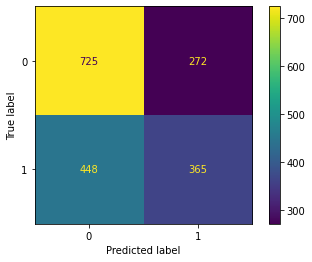

In [199]:
CM = confusion_matrix(ytest, ypred)

CMnorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMnorm.plot()
plt.show()

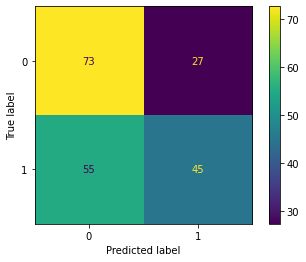

In [200]:
CMnorm = confusion_matrix(ytest, ypred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=CMnorm*100, display_labels=logRegModel.classes_)
disp.plot()
plt.show()

In [201]:
precision0 = CM[0][0] / (CM[0][0] + CM[1][0])
print("Precision 0:",precision0*100)
recall0 = CM[0][0] / (CM[0][0] + CM[0][1])
print("Recall 0:",recall0*100, "\n")

precision1 = CM[1][1] / (CM[0][1] + CM[1][1])
print("Precision 1:",precision1*100)
recall1 = CM[1][1] / (CM[1][0] + CM[1][1])
print("Recall 1:",recall1*100, "\n")

Precision 0: 61.807331628303494
Recall 0: 72.71815446339018 

Precision 1: 57.299843014128726
Recall 1: 44.895448954489545 



#Bayes

In [202]:
nb = GaussianNB()
nb.fit(X, y)
ypred = nb.predict(Xtest)

print("Exactitud del modelo", nb.score(Xtest, ytest))


Exactitud del modelo 0.6071823204419889


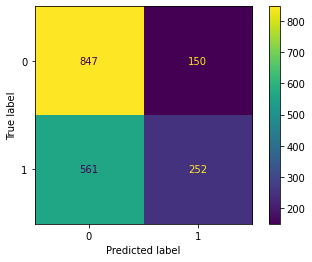

In [203]:
CM = confusion_matrix(ytest, ypred)

CMnorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMnorm.plot()
plt.show()

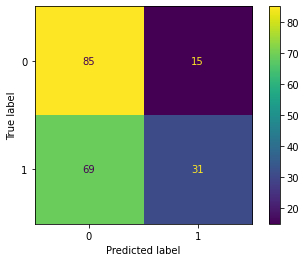

In [204]:
CMnorm = confusion_matrix(ytest, ypred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=CMnorm*100, display_labels=logRegModel.classes_)
disp.plot()
plt.show()

In [205]:
precision0 = CM[0][0] / (CM[0][0] + CM[1][0])
print("Precision 0:",precision0*100)
recall0 = CM[0][0] / (CM[0][0] + CM[0][1])
print("Recall 0:",recall0*100, "\n")

precision1 = CM[1][1] / (CM[0][1] + CM[1][1])
print("Precision 1:",precision1*100)
recall1 = CM[1][1] / (CM[1][0] + CM[1][1])
print("Recall 1:",recall1*100, "\n")

Precision 0: 60.15625
Recall 0: 84.95486459378134 

Precision 1: 62.68656716417911
Recall 1: 30.996309963099634 



#KNN

In [206]:
error = []

for i in range(1,100):
 kNN = KNeighborsClassifier(n_neighbors=i)
 kNN.fit(X, y)
 ypred = kNN.predict(Xtest)
 error.append(np.mean(ypred != ytest))

k = error.index(min(error))
print("Minimum error:-",min(error))
print("k = ", k)

Minimum error:- 0.39226519337016574
k =  59


In [207]:
kNN    = KNeighborsClassifier(n_neighbors=k)
kNN.fit(X, y)
ypred = kNN.predict(Xtest)

print("Exactitud del modelo", kNN.score(Xtest, ytest))

Exactitud del modelo 0.5972375690607735


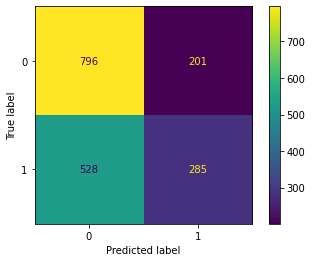

In [208]:
CM = confusion_matrix(ytest, ypred)

CMnorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMnorm.plot()
plt.show()

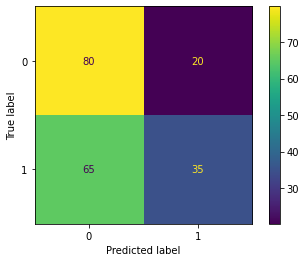

In [209]:
CMnorm = confusion_matrix(ytest, ypred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=CMnorm*100, display_labels=logRegModel.classes_)
disp.plot()
plt.show()

In [210]:
precision0 = CM[0][0] / (CM[0][0] + CM[1][0])
print("Precision 0:",precision0*100)
recall0 = CM[0][0] / (CM[0][0] + CM[0][1])
print("Recall 0:",recall0*100, "\n")

precision1 = CM[1][1] / (CM[0][1] + CM[1][1])
print("Precision 1:",precision1*100)
recall1 = CM[1][1] / (CM[1][0] + CM[1][1])
print("Recall 1:",recall1*100, "\n")

Precision 0: 60.12084592145015
Recall 0: 79.839518555667 

Precision 1: 58.64197530864198
Recall 1: 35.05535055350554 



# Random forest

In [211]:
rfc = RandomForestClassifier()
rfc.fit(X, y)
ypred = rfc.predict(Xtest)

print("Exactitud del modelo", rfc.score(Xtest, ytest))

Exactitud del modelo 0.5712707182320442


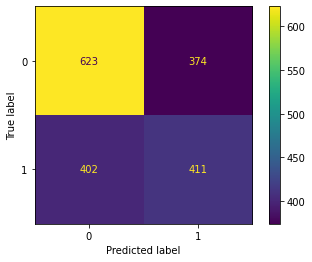

In [212]:
CM = confusion_matrix(ytest, ypred)

CMnorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMnorm.plot()
plt.show()

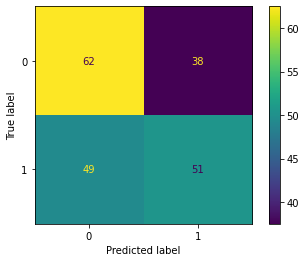

In [213]:
CMnorm = confusion_matrix(ytest, ypred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=CMnorm*100, display_labels=logRegModel.classes_)
disp.plot()
plt.show()

In [214]:
precision0 = CM[0][0] / (CM[0][0] + CM[1][0])
print("Precision 0:",precision0*100)
recall0 = CM[0][0] / (CM[0][0] + CM[0][1])
print("Recall 0:",recall0*100, "\n")

precision1 = CM[1][1] / (CM[0][1] + CM[1][1])
print("Precision 1:",precision1*100)
recall1 = CM[1][1] / (CM[1][0] + CM[1][1])
print("Recall 1:",recall1*100, "\n")

Precision 0: 60.78048780487805
Recall 0: 62.487462387161486 

Precision 1: 52.35668789808917
Recall 1: 50.55350553505535 



## kmeans

In [215]:
km =  KMeans(n_clusters=2, random_state=0).fit(X)
ypred = km.predict(Xtest)

print("Exactitud del modelo", km.score(Xtest, ytest))

Exactitud del modelo -11856.432070877672


In [216]:
ytest[ytest == 2] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [217]:
print("Inercia del modelo", km.inertia_)

Inercia del modelo 18380.29944564859


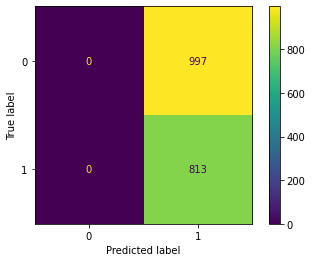

In [218]:
CM = confusion_matrix(ytest, ypred)

CMnorm = ConfusionMatrixDisplay(confusion_matrix=CM)
CMnorm.plot()
plt.show()

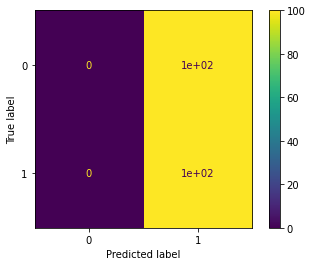

In [219]:
CMnorm = confusion_matrix(ytest, ypred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=CMnorm*100, display_labels=logRegModel.classes_)
disp.plot()
plt.show()

In [220]:
precision0 = CM[0][0] / (CM[0][0] + CM[1][0])
print("Precision 0:",precision0*100)
recall0 = CM[0][0] / (CM[0][0] + CM[0][1])
print("Recall 0:",recall0*100, "\n")

precision1 = CM[1][1] / (CM[0][1] + CM[1][1])
print("Precision 1:",precision1*100)
recall1 = CM[1][1] / (CM[1][0] + CM[1][1])
print("Recall 1:",recall1*100, "\n")

Precision 0: nan
Recall 0: 0.0 

Precision 1: 44.9171270718232
Recall 1: 100.0 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.
